<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/02_Convolutional_Neural_Networks_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!nvidia-smi

Wed Mar 10 23:29:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction to Computer Vision / CNN with TensorFlow
Computer vision is a practice of writing algorithm which can discover patters in visual data. Such as a camera of a self-driving car recognizing the car in front.
## What we're going to cover?

- Getting a dataset to work with (pizza_steak). 
- Architecture of a **convolutional neural network** (CNN) with TensorFlow. 
- And end-to-end binary image classification problem. 
- Steps in modelling with CNNs. 
  * Creating a CNN model. 
  * Compiling a model.
  * Fitting a model. 
  * Evaluating a model
* An end-to-end multi-class image classification problem. 
* Making predicitons on our custom images.

In [4]:
import tensorflow as tf

## Get the data 

The images we're working with are from the Food101 dataset(101 different classes). However we've modified it to only use two classes (pizza and steak) using the [image data modification notebook ](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)

🔑 **Note:** We start with smaller dataset so we can experiment quickly and figure out what works (or better yet what doesn't) before scaling up. 

In [6]:
import zipfile 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip # get this file and download it

# Unzip the downloaded file 
zip_ref = zipfile.ZipFile('/content/pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2021-03-10 20:08:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.164.176, 172.217.7.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.50M   122MB/s    in 0.9s    

2021-03-10 20:08:12 (122 MB/s) - ‘pizza_steak.zip.1’ saved [109579078/109579078]



## Inspecting the data (Becoming one with the data)
We gotta draw a idea about the data in our mind before writing any code at first. 

A very crucial step at the beginning of any machine learning project is to become one with the data. And for computer vision project this usually means visualizing many samples of our data. 


In [7]:
# List the files in the folder
!ls pizza_steak/

test  train


In [9]:
# Into the train folder 
!ls pizza_steak/train

pizza  steak


In [10]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

Wow! that's a bunch of images, let's find how many of them are in there. 

In [63]:
import os

# Walk through pizza_steak directory and list number of files 
for dirpath , dirnames , filenames in os.walk('pizza_steak'): # pass in the file you wanna walkthrough
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}"')



There are 2 directories and 1 images in "pizza_steak"
There are 2 directories and 1 images in "pizza_steak/train"
There are 0 directories and 750 images in "pizza_steak/train/pizza"
There are 0 directories and 750 images in "pizza_steak/train/steak"
There are 2 directories and 1 images in "pizza_steak/test"
There are 0 directories and 250 images in "pizza_steak/test/pizza"
There are 0 directories and 250 images in "pizza_steak/test/steak"


`.DS_Store` --> considered as a image in the directory
- pizza
  * train --> 750 images
  * test --> 250 images
- steak 
  * train --> 750 images
  * test --> 250 images

We just saw how to see the filenames in the directory, now will look into how a image looks exactly by visualizing it. 

In [65]:
# Another way to find out how many images are in a file 
num_steak_images_train = len(os.listdir('pizza_steak/train/steak')) # directly inspecting with listdir
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically. 

In [66]:
# Get the class names programmatically
import pathlib 
import numpy as np 
data_dir = pathlib.Path('pizza_steak/train') # turned into a path object 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # Creates a list of class names from sub directories
class_names = class_names[1:] # indexing off DS_STORE
print(class_names)

['pizza' 'steak']


**Let's Visualize some images**

In [67]:
# Visualzing the images 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 
import random 

def view_random_image(target_dir , target_class): 
  '''
  Select an image randomly from the path regardless the class and plot the image for us. 
  '''
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class
  
  # Get a random image path 
  random_image = random.sample(os.listdir(target_folder) , 1) # randomly get one (1) of the items from here
  print(f'The random_image variable returns: {random_image}')

  # Read in the image and plot it using matplotlib 
  # img = mpimg.imread(target_folder + '/' + random_image[0])
  img = cv2.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class) # Displaying whether it's pizza or steak depending upon the image getting plotted
  plt.axis('off'); # we don't want the axes

  print(f'Image shape: {img.shape}') # show the shape of a image

  return img # returns a image at a last

The random_image variable returns: ['564530.jpg']
Image shape: (512, 512, 3)


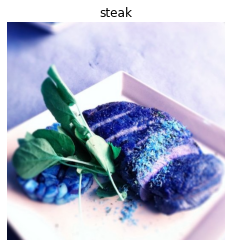

In [68]:
# View random image from the training dataset 
img = view_random_image(target_dir= 'pizza_steak/train/' , 
                        target_class = 'steak') # wanna see a image of steak

The random_image variable returns: ['1384464.jpg']
Image shape: (306, 512, 3)


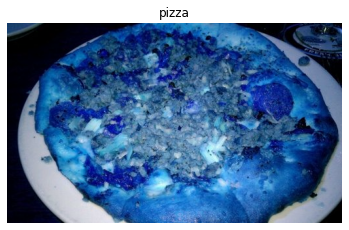

In [69]:
# Let's check soem pizza images 
pizza_img = view_random_image(target_dir = 'pizza_steak/train/' , 
                              target_class = 'pizza')

In [70]:
# What does img looks like ? 
img

array([[[ 19,  31, 103],
        [ 19,  31, 103],
        [ 19,  31, 103],
        ...,
        [237, 236, 240],
        [231, 230, 234],
        [227, 226, 230]],

       [[ 20,  32, 104],
        [ 20,  32, 104],
        [ 19,  31, 103],
        ...,
        [241, 240, 244],
        [236, 235, 239],
        [233, 232, 236]],

       [[ 18,  31, 105],
        [ 18,  31, 105],
        [ 18,  31, 105],
        ...,
        [245, 244, 248],
        [242, 241, 245],
        [239, 238, 242]],

       ...,

       [[  8,  13,  44],
        [  8,  13,  44],
        [  8,  13,  44],
        ...,
        [246, 244, 250],
        [245, 242, 251],
        [244, 241, 250]],

       [[  6,  14,  44],
        [  6,  14,  44],
        [  8,  13,  44],
        ...,
        [245, 242, 251],
        [246, 241, 250],
        [246, 241, 250]],

       [[  7,  15,  45],
        [  6,  14,  44],
        [  8,  13,  44],
        ...,
        [245, 242, 251],
        [246, 241, 250],
        [246, 241, 250]]

In [71]:
# Turning the array into a tensor 
tf.constant(img) # pre-processing array into tensors

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 19,  31, 103],
        [ 19,  31, 103],
        [ 19,  31, 103],
        ...,
        [237, 236, 240],
        [231, 230, 234],
        [227, 226, 230]],

       [[ 20,  32, 104],
        [ 20,  32, 104],
        [ 19,  31, 103],
        ...,
        [241, 240, 244],
        [236, 235, 239],
        [233, 232, 236]],

       [[ 18,  31, 105],
        [ 18,  31, 105],
        [ 18,  31, 105],
        ...,
        [245, 244, 248],
        [242, 241, 245],
        [239, 238, 242]],

       ...,

       [[  8,  13,  44],
        [  8,  13,  44],
        [  8,  13,  44],
        ...,
        [246, 244, 250],
        [245, 242, 251],
        [244, 241, 250]],

       [[  6,  14,  44],
        [  6,  14,  44],
        [  8,  13,  44],
        ...,
        [245, 242, 251],
        [246, 241, 250],
        [246, 241, 250]],

       [[  7,  15,  45],
        [  6,  14,  44],
        [  8,  13,  44],
        ...,
        [245, 242, 25

In [72]:
img / 255

array([[[0.0745098 , 0.12156863, 0.40392157],
        [0.0745098 , 0.12156863, 0.40392157],
        [0.0745098 , 0.12156863, 0.40392157],
        ...,
        [0.92941176, 0.9254902 , 0.94117647],
        [0.90588235, 0.90196078, 0.91764706],
        [0.89019608, 0.88627451, 0.90196078]],

       [[0.07843137, 0.1254902 , 0.40784314],
        [0.07843137, 0.1254902 , 0.40784314],
        [0.0745098 , 0.12156863, 0.40392157],
        ...,
        [0.94509804, 0.94117647, 0.95686275],
        [0.9254902 , 0.92156863, 0.9372549 ],
        [0.91372549, 0.90980392, 0.9254902 ]],

       [[0.07058824, 0.12156863, 0.41176471],
        [0.07058824, 0.12156863, 0.41176471],
        [0.07058824, 0.12156863, 0.41176471],
        ...,
        [0.96078431, 0.95686275, 0.97254902],
        [0.94901961, 0.94509804, 0.96078431],
        [0.9372549 , 0.93333333, 0.94901961]],

       ...,

       [[0.03137255, 0.05098039, 0.17254902],
        [0.03137255, 0.05098039, 0.17254902],
        [0.03137255, 0

In [73]:
# View the image shape 
img.shape # return (width , height , color channel)

(512, 512, 3)

We can pass this array in our model, but it's often important to pre-process our data before injecting them into a model or other words **(scale or normalize our data)**. 

In [74]:
# Get all the pixel values btw 0 and 1
img / 255.

array([[[0.0745098 , 0.12156863, 0.40392157],
        [0.0745098 , 0.12156863, 0.40392157],
        [0.0745098 , 0.12156863, 0.40392157],
        ...,
        [0.92941176, 0.9254902 , 0.94117647],
        [0.90588235, 0.90196078, 0.91764706],
        [0.89019608, 0.88627451, 0.90196078]],

       [[0.07843137, 0.1254902 , 0.40784314],
        [0.07843137, 0.1254902 , 0.40784314],
        [0.0745098 , 0.12156863, 0.40392157],
        ...,
        [0.94509804, 0.94117647, 0.95686275],
        [0.9254902 , 0.92156863, 0.9372549 ],
        [0.91372549, 0.90980392, 0.9254902 ]],

       [[0.07058824, 0.12156863, 0.41176471],
        [0.07058824, 0.12156863, 0.41176471],
        [0.07058824, 0.12156863, 0.41176471],
        ...,
        [0.96078431, 0.95686275, 0.97254902],
        [0.94901961, 0.94509804, 0.96078431],
        [0.9372549 , 0.93333333, 0.94901961]],

       ...,

       [[0.03137255, 0.05098039, 0.17254902],
        [0.03137255, 0.05098039, 0.17254902],
        [0.03137255, 0

🔑 **Dan Note:** As we've discussed before, many machine learning models, including neural networks perfer the values they work with to be between 0 and 1. Knowing this, one of the most common pre-processing steps for working with images is to **scale** (also reffered to as **normalize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value). 

## An end-to-end example 

Let's build a cnn to find patterns in our images, more specifically we need a way to: 
- Load our images. 
- Pre-process our images. (scale)
- Build a cnn model to find patterns in our images
- Compile the cnn model. 
- Fit the cnn model. 

In [75]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed 
tf.random.set_seed(42)

# Pre-process data (gets all of the pixel values between 0 and 1, also called scaling , normalization)
# To do this we're going to setup two instances of ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Setup paths to our data directories
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# Import data from directories and turn it into batches
# It gets data and create labels automatically for us
train_data = train_datagen.flow_from_directory(directory = train_dir , 
                                               batch_size = 32 , 
                                               target_size = (224 , 224) , 
                                               class_mode = 'binary' , 
                                               seed = 42) # passing the train_dir into the datagenerator

valid_data = valid_datagen.flow_from_directory(directory = test_dir , 
                                               batch_size = 32 , 
                                               target_size = (224 , 224) , 
                                               class_mode = 'binary' , 
                                               seed = 42)

# Building a CNN model (same as a Tiny VGG model)
model_0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10 , 
                           kernel_size = 3 , 
                           activation = tf.keras.activations.relu , 
                           input_shape = (224, 224 , 3)),  # input shape our first layer is gonna take

    tf.keras.layers.Conv2D(10 , 3 , activation= tf.keras.activations.relu) , 
    tf.keras.layers.MaxPool2D(pool_size= 2, 
                              padding = 'valid'), 
    tf.keras.layers.Conv2D(10 , 3, activation= tf.keras.activations.relu), 
    tf.keras.layers.Conv2D(10 , 3 , activation= tf.keras.activations.relu) , 
    tf.keras.layers.MaxPool2D(2) , 
    tf.keras.layers.Flatten() ,  # flattening before sending to output layer
    tf.keras.layers.Dense(1 , activation= tf.keras.activations.sigmoid)
])

# Compile our CNN model 
model_0.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [80]:
# Fit the model 
history_0 = model_0.fit(train_data , epochs = 5 , 
                        steps_per_epoch = len(train_data) , # 47 steps per epoch
                        validation_data =  valid_data , 
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 42s 204ms/step - loss: 0.6227 - accuracy: 0.6360 - val_loss: 0.4442 - val_accuracy: 0.7680
Epoch 2/5
47/47 [==============================] - 9s 191ms/step - loss: 0.4232 - accuracy: 0.8282 - val_loss: 0.3403 - val_accuracy: 0.8560
Epoch 3/5
47/47 [==============================] - 9s 191ms/step - loss: 0.3744 - accuracy: 0.8224 - val_loss: 0.3226 - val_accuracy: 0.8640
Epoch 4/5
47/47 [==============================] - 9s 189ms/step - loss: 0.3362 - accuracy: 0.8538 - val_loss: 0.2847 - val_accuracy: 0.8840
Epoch 5/5
47/47 [==============================] - 9s 190ms/step - loss: 0.3156 - accuracy: 0.8784 - val_loss: 0.3313 - val_accuracy: 0.8740


**Breaking down the code above**
- `target_size` --> A default size we want all of our images should be, for instance images with different shapes might exists in there. But we want to turn all them into a uniform stable size. 
- `class_mode = 'binary'` --> we are importing our data in a binary (2 classes) or we are dealing with a binary classification problem. 

In [79]:
# Checking how our data is been taken into the model 
print(f'We have {len(train_data)} batches of 32 images in each of them')
print(f'Its by the calculation 1500 / 32 = {1500 / 32}')

We have 47 batches of 32 images in each of them
Its by the calculation 1500 / 32 = 46.875
